# Fit with a mixture model (Prentice et al 2016), the pseudo-retinal data generated by Gasper

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Gasper:  
For subsets of 120 out of the 160 neurons in the above dataset (random subset), I can generate a family of k-Pairwise maxent models, as described in the criticality PNAS and the PLOS CB, where what is being varied is the strength of interactions in the energy function, while guaranteeing that the firing rates of all the neurons are kept fixed. I have parameters for the corresponding probabilistic models and a monte carlo that can sample from this.

Concretely, for a single fixed group of 120 neurons, I’ve created 20 sample sets for you, each containing 200.000 samples drawn from the k-Pairwise maxent model for these 120 neurons (synthset_samps_1 … synthset_samps_20). The different synthsets differ in the multiplication factor in front of the interaction energy terms, going from 0 in synthset_1 (= cond. ind. model) through 1 in synthset_11 (= mimicking real data) to synthset_20 (1.9x higher interaction energy terms). As a check that the mean firing rates are properly refit, in every synthset you will find mv0, the average probability of spiking for each of the 120 neurons in the data, and mv, the probability of spiking in the synthset model; these should very closely match.

Consistent with the PNAS Criticality results, it is interesting to note that the variance of energy (or log probability under the probabilistic model) is highest for the synthsets close to real data (= synthset_11 or 12). 

In [2]:
import scipy.io

In [13]:
#dataFileBase = 'Learnability_data/synthset_samps_1'
#dataFileBase = 'Learnability_data/synthset_samps_11'
#dataFileBase = 'Learnability_data/synthset_samps_20'
dataFileBase = 'IST-2017-61-v1+1_bint_fishmovie32_100'

In [14]:
# load the dataset _11 that mimicks real data
retinaData = scipy.io.loadmat(dataFileBase+'.mat')
print(retinaData.keys())
if 'IST' in dataFileBase:
    # load the experimentally observed retinal dataset:
    spikeRaster = retinaData['bint']
    print(spikeRaster.shape)
    spikeRaster = np.reshape(np.moveaxis(spikeRaster,0,-1),(160,-1))
    print(spikeRaster.shape)
else:
    # load the model generated dataset
    print(retinaData['synthset'].dtype)
    print(retinaData['synthset']['smp'])
    print("Shape of retinal Data = ",retinaData['synthset']['smp'][0,0].shape)
    spikeRaster = retinaData['synthset']['smp'][0,0]
    referenceRates = retinaData['synthset']['mv0'][0,0][0]
    sampleRates = retinaData['synthset']['mv'][0,0][0]

dict_keys(['__header__', '__version__', '__globals__', 'bint'])
(297, 160, 953)
(160, 283041)


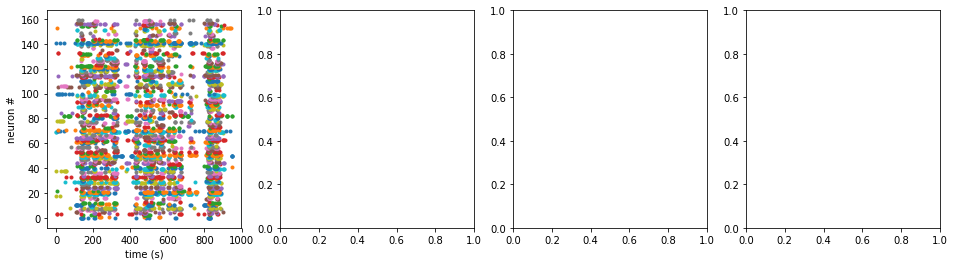

In [7]:
nNeurons,tSteps = spikeRaster.shape
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
for i in range(nNeurons):
    spike_times = np.where(spikeRaster[i,:1000]==1)[0]
    if len(spike_times)>0:
        axes[0].plot(spike_times,[i]*len(spike_times),'.')
    axes[0].set_xlabel('time (s)')
    axes[0].set_ylabel('neuron #')
# the samples are already in 20ms bins!
if 'IST' not in dataFileBase:
    for i in range(3):
        axes[i+1].hist( (np.sum(spikeRaster,axis=1)/tSteps/0.02, sampleRates, referenceRates)[i],
                   color=('r','g','b')[i] )
        axes[i+1].set_xlabel( ('rate (Hz)','prob','prob')[i] )
        axes[i+1].set_ylabel('count')

## The samples are already in 20ms bins.

In [8]:
# test np.reshape() and np.unique() with axis
#print( np.reshape([[1,2,3,4],[5,6,7,8]], (2,2,-1)) )
#print( np.unique([[1,2,3,1,2],[4,5,6,4,6]], axis=1) )

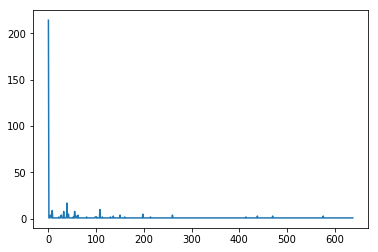

In [9]:
## no need of the below -- the samples are already in 20ms bins!
## bin into 20ms bins
#spikeRasterBinned = np.sum( np.reshape(spikeRaster,(Nneurons,tSteps//20,20)), axis=2)
## bins with > 1 spikes are set to 1
#spikeRasterBinned[spikeRasterBinned>0] = 1

# find unique spike patterns and their counts
spikePatterns, patternCounts = np.unique(spikeRaster, return_counts=True, axis=1)
plt.plot(patternCounts)

In [10]:
class MixtureModel():
    def __init__(self,nModes,spikeRaster):
        np.random.seed(1)
        self.nModes = nModes
        self.nNeurons,self.tSteps = spikeRaster.shape
        self.wModes = np.zeros(nModes)
        self.spikeRaster = spikeRaster # nNeurons x tSteps
        self.oneMinusSpikeRaster = 1. - spikeRaster
        self.QModes = np.zeros((nModes,self.tSteps))
        self.mProb = np.zeros((nModes,nNeurons))
        self.PCond = np.random.uniform(size=(self.nModes,self.tSteps))

    def expectation(self):
        zeroesVec = self.spikeRaster == 0
        for mode in range(self.nModes):
            # np.broadcast_to() only creates a read-only view, need to copy to modify
            mProbBroadcast = np.copy(
                            np.broadcast_to( np.transpose([self.mProb[mode,:]]),
                                            (self.nNeurons,self.tSteps) ) )
            mProbBroadcast[zeroesVec] = 1. - mProbBroadcast[zeroesVec]
            self.QModes[mode,:] = np.product( mProbBroadcast, axis=0 )
        self.PCond = (self.wModes[:, np.newaxis] * self.QModes) \
                        / np.dot(self.wModes,self.QModes)
        
    def maximization(self):
        self.wModes = 1./(self.tSteps+1.) * np.sum(self.PCond,axis=1)
        self.mProb = np.dot(self.PCond,self.spikeRaster.T) \
                        / np.sum(self.PCond,axis=1)[:, np.newaxis]
        

In [10]:
mixMod = MixtureModel(nModes=70,spikeRaster=spikeRaster)
nCol = 4
fig, axes = plt.subplots(nrows=1, ncols=nCol, figsize=(16,4))
nRepeat = 40
currAxNum = 0
for i in range(nRepeat):
    mixMod.maximization()
    mixMod.expectation()
    if i%(nRepeat//4) == nRepeat-1:
        axes[currAxNum].plot(np.sort(mixMod.wModes)[::-1])
        axes[currAxNum].set_xlabel( 'mode #' )
        axes[currAxNum].set_ylabel('prob')
        currAxNum += 1

NameError: name 'MixtureModel' is not defined

In [11]:
import shelve

In [345]:
# Save the fitted model
dataBase = shelve.open(dataFileBase+'_mixmod.shelve')
dataBase['mixMod'] = mixMod
dataBase.close()

In [12]:
# Load the fitted model
dataBase = shelve.open(dataFileBase+'_mixmod.shelve')
mixMod = dataBase['mixMod']
dataBase.close()

error: Bad magic number

In [13]:
# calculate mean spike count for each mode and sort by mode weight:
meanSpikesMode = np.sum(mixMod.mProb,axis=1)
sortedIdxs = np.argsort(mixMod.wModes)[::-1]
print(meanSpikesMode[sortedIdxs])

NameError: name 'mixMod' is not defined

In [14]:
from sklearn.manifold import MDS

In [248]:
# testing multi-dimensional scaling on sklearn's inbuilt dataset
from sklearn.datasets import load_digits

X,y = load_digits(return_X_y=True)
print(X.shape,y.shape)

embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(X[:100])
print(X_transformed.shape)

(1797, 64) (1797,)
(100, 2)


In [15]:
# non-linear dimensionality reduction from nNeurons-dim to 2-dim
#  using multi-dimensional scaling
lowDimMDS = MDS(n_components=2)
# mixMod.mProb has shape nModes x nNeurons
lowDimData = lowDimMDS.fit_transform(mixMod.mProb)
# lowDimData has shape nModes x n_components

NameError: name 'mixMod' is not defined

Text(0.5,1,'log w')

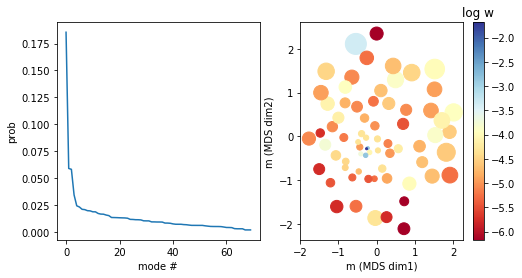

In [250]:
# plotting figures 3a and 3b of Prentice et al 2016
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

axes[0].plot(np.sort(mixMod.wModes)[::-1])
axes[0].set_xlabel( 'mode #' )
axes[0].set_ylabel('prob')

cm = plt.cm.get_cmap('RdYlBu')
x,y = lowDimData.T
s = axes[1].scatter(x,y,c=np.log(mixMod.wModes),s=meanSpikesMode*20,cmap=cm)
cbar = fig.colorbar(s)
axes[1].set_xlabel('m (MDS dim1)')
axes[1].set_ylabel('m (MDS dim2)')
cbar.ax.set_title(r"log w")  
#cbar.ax.set_ylabel(r"log w",  labelpad=20, rotation=270)

In [251]:
# Compute the function being maximized by the EM above and report its value:
print('The log likelihood of the model is ',np.sum(mixMod.PCond*mixMod.QModes))

The log likelihood of the model is  166.059525996


In [252]:
# compute entropy of retinal data
# number of modes is arbitrary, so not looking at entropy per mode,
#  or entropy for a given mode
#     (roughly proportional to mean spike count (size of circles above) see fig 3c).

# compute entropy of spike patterns (patternCounts defined above)
pSpikePatterns = patternCounts / np.float(mixMod.tSteps)
print("Entropy of spike patterns is ",-np.sum(pSpikePatterns*np.log(pSpikePatterns)))

## Below is wrong! Qmodes is not probability of mode at any given tStep!
## In fact, below gives a smaller entropy for independent model _1 compared to experimental
## compute entropy of mode patterns, Qmodes has shape nModes x tSteps
## we compute the probability of a mode occuring across time
#pModePatterns = np.sum(mixMod.QModes,axis=1) / np.float(mixMod.tSteps)
#print("Entropy of mode patterns is ",-np.sum(pModePatterns*np.log(pModePatterns)))

# compute entropy of mode patterns
print("Entropy of mode patterns is ",-np.sum(mixMod.wModes*np.log(mixMod.wModes)))

Entropy of spike patterns is  5.42828221143
Entropy of mode patterns is  3.70552514745


In [16]:
from sklearn import discriminant_analysis as DA

Linear discriminant analysis on all modes using  1  components, training score is 0.950980392157
Linear discriminant analysis on all modes using  1  components, test score is 0.573221757322


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


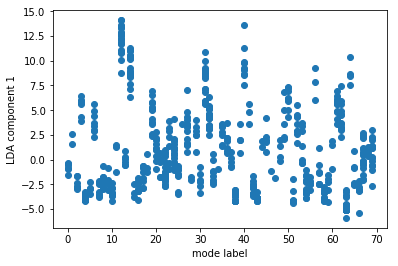

In [254]:
# Qmodes is nModes x tSteps, modeDataLabels is (tSteps,)
modeDataLabels = np.argmax(mixMod.QModes,axis=0).T
# spikeRaster is nNeurons x tSteps
# LDA.fit_transform() requires samples x features i.e. tSteps x nNeurons
# number of components doesn't matter in the least for accuracy!
numComponents = 1
LDA = DA.LinearDiscriminantAnalysis(n_components=numComponents)
modeDataLDA = LDA.fit_transform(mixMod.spikeRaster[:,:-mixMod.tSteps//4].T,
                                    modeDataLabels[:-mixMod.tSteps//4])
# modeDataLDA is (tSteps,)
print('Linear discriminant analysis on all modes using ',
              numComponents,' components, training score is',
              LDA.score(mixMod.spikeRaster[:,:-mixMod.tSteps//4].T,
                        modeDataLabels[:-mixMod.tSteps//4]))
print('Linear discriminant analysis on all modes using ',
              numComponents,' components, test score is',
              LDA.score(mixMod.spikeRaster[:,-mixMod.tSteps//4:].T,
                        modeDataLabels[-mixMod.tSteps//4:]))
plt.scatter(modeDataLabels[:-mixMod.tSteps//4],modeDataLDA[:,0])
plt.xlabel('mode label')
plt.ylabel('LDA component 1');